In [7]:
## Package management

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random

## SIS MODEL SIMULATION

In [29]:
def sis_model(G, gamma, beta, num_iterations, infected_percent):
    # Initialize the number of infected and susceptible nodes
    infected = set()
    susceptible = set(G.nodes())

    # Initialize the list of infected and susceptible nodes at each time step
    infected_list = []
    susceptible_list = []

    # Choose a random subset of nodes to start the infection
    num_infected = int(len(G) * infected_percent)
    infected = set(random.sample(susceptible, num_infected))
    susceptible -= infected

    # Iterate for the specified number of iterations
    for t in range(num_iterations):
        # Compute the transition probabilities for each node
        for node in G.nodes():
            p_infect = len([n for n in G.neighbors(node) if n in infected]) / len(G)
            p_recover = gamma
            
            # Transition the node to the infected state with probability p_infect
            # or to the susceptible state with probability p_recover
            if node in infected:
                if random.random() < p_recover:
                    infected.remove(node)
                    susceptible.add(node)
            elif node in susceptible:
                if random.random() < p_infect:
                    infected.add(node)
                    susceptible.remove(node)
        
        # Append the number of infected and susceptible nodes to the list
        infected_list.append(len(infected))
        susceptible_list.append(len(susceptible))

    return infected_list, susceptible_list


#### Complete graph

/var/folders/n5/ktlz2xtn5vs65v3vw81n10k80000gn/T/ipykernel_33268/2815927380.py:12: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  infected = set(random.sample(susceptible, num_infected))


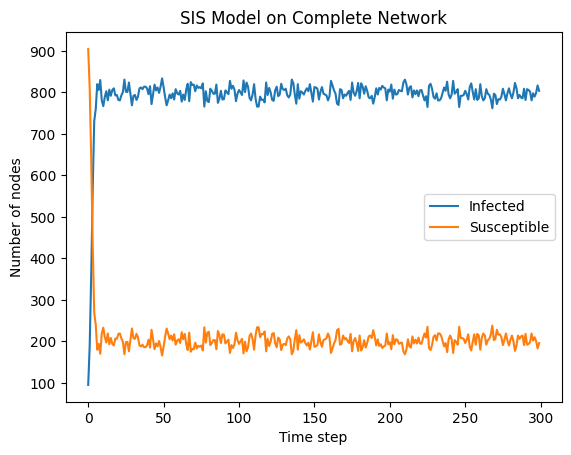

In [32]:
G = nx.complete_graph(1000)
infected, susceptible = sis_model(G, gamma=0.2, beta=0.1, num_iterations=300,infected_percent=0.05)

## Plot  the result
plt.figure()
plt.plot(infected, label='Infected')
plt.plot(susceptible, label='Susceptible')
plt.legend()
plt.xlabel('Time step')
plt.ylabel('Number of nodes')
plt.title('SIS Model on Complete Network')
plt.show()